In [ ]:
# META DATA - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    # Developer details: 
        # Name: Khushboo Mittal, Prachi Tavse, Tanisha Priya, Harshita Jangde 
        # Role: Architect
    # Version:
        # Version: V 1.0 (24 October 2024)
            # Developers: Khushboo Mittal, Prachi Tavse, Tanisha Priya, Harshita Jangde 
            # Unit test: Pass
            # Integration test: Pass
     
     # Description: This code snippet implements an Encoder-Decoder model for Natural Language Processing (NLP) 
     # tasks, focusing on sequence-to-sequence transformation. The model uses embedding layers for input 
     # encoding, followed by an RNN (GRU) architecture in the encoder to capture sequential dependencies. 
     # The decoder generates output sequences based on the encoded context. Applications include text translation, 
     # summarization, and question answering, with support for custom vocabularies and tokenization.

# CODE - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    # Dependency: 
        # Environment:     
            # Python: 3.11.0
            # torch: 2.1.0
            # torchtext: 0.16.0
            # sklearn: 1.5.0
            # pandas: 2.2.2
            # matplotlib: 3.8.2

import pandas as pd  # Import pandas for data manipulation
from sklearn.model_selection import train_test_split  # Import function for splitting datasets
import torch  # Import PyTorch for tensor operations
from torchtext.data.utils import get_tokenizer  # Import tokenizer utility from torchtext
from torchtext.vocab import build_vocab_from_iterator  # Import function to build vocabulary from text
from torch.utils.data import Dataset, DataLoader  # Import classes for dataset handling
from torch.nn.utils.rnn import pad_sequence  # Import function to pad sequences for batching
from sklearn.metrics import accuracy_score, classification_report # Import the function for evaluation metrics
import matplotlib.pyplot as plt # Import matplotlib for visualisation

# Define column names for the dataset
column_names = ['tweetID', 'entity', 'sentiment', 'tweet_content']

# Load the dataset with specified column names; no header in the CSV
df = pd.read_csv('../Data/twitter_sentiment_analysis.csv', names=column_names, header=None)

print("Initial dataset information:")
print(df.info())  # Show basic info
print(df.head())  # Show first few rows

Initial dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweetID        1006 non-null   int64 
 1   entity         1006 non-null   object
 2   sentiment      1006 non-null   object
 3   tweet_content  1002 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.6+ KB
None
   tweetID       entity sentiment  \
0     2401  Borderlands  Positive   
1     2401  Borderlands  Positive   
2     2401  Borderlands  Positive   
3     2401  Borderlands  Positive   
4     2401  Borderlands  Positive   

                                       tweet_content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ... 

In [2]:
df = df[['tweetID', 'sentiment', 'tweet_content']]  # Select only relevant columns
# Basic preprocessing of sentiment labels and tweet content
df['sentiment'] = df['sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2, 'Irrelevant': 3})  # Encode sentiments as integers
df['tweet_content'] = df['tweet_content'].astype(str)  # Ensure tweet content is of string type
df.dropna(subset=['sentiment'], inplace=True)  # Remove rows with missing sentiment values

print("Dataset after preprocessing:")
print(df.info())
print(df.head())

Dataset after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweetID        1006 non-null   int64 
 1   sentiment      1006 non-null   int64 
 2   tweet_content  1006 non-null   object
dtypes: int64(2), object(1)
memory usage: 23.7+ KB
None
   tweetID  sentiment                                      tweet_content
0     2401          1  im getting on borderlands and i will murder yo...
1     2401          1  I am coming to the borders and I will kill you...
2     2401          1  im getting on borderlands and i will kill you ...
3     2401          1  im coming on borderlands and i will murder you...
4     2401          1  im getting on borderlands 2 and i will murder ...


In [3]:
# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)  # 15% of data for testing
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)  # Split remaining data into valid and test sets

print(f"Training set size: {len(train_df)}, Validation set size: {len(valid_df)}, Test set size: {len(test_df)}")

Training set size: 855, Validation set size: 75, Test set size: 76


Vocabulary size: 2250
Most common tokens:
[('.', 2975), ('i', 726), ('the', 696), ('borderlands', 602), ('!', 547), ('to', 469), ('and', 468), (',', 434), ('a', 409), ("'", 374)]

Least common tokens:
[('hive', 1), ('counting', 1), ('dubbed', 1), ('single', 1), ('eight', 1), ('mine', 1), ('underpaying', 1), ('badly', 1), ('sweat', 1), ('planning', 1)]


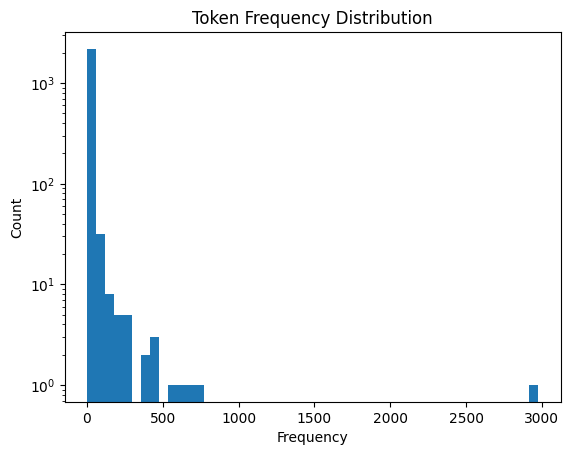

In [5]:
# Tokenization using a basic English tokenizer
tokenizer = get_tokenizer("basic_english")

# Function to yield tokens for vocabulary creation
def yield_tokens(data_iter):
    for tweet in data_iter:  # Iterate through each tweet
        yield tokenizer(tweet)  # Tokenize and yield tokens

# Build vocabulary from the tokenized tweets, including a special unknown token
vocab = build_vocab_from_iterator(yield_tokens(df['tweet_content']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # Set default index for unknown words to the unknown token

print(f"Vocabulary size: {len(vocab)}")

# Display the most common and least common tokens in the vocabulary
token_freq = vocab.get_stoi()  # Get the token-to-index mapping (vocabulary)
print("Most common tokens:")
# Count token frequencies by iterating through the dataset (you can also use collections.Counter)
token_counts = {}
for tweet in df['tweet_content']:
    for word in tokenizer(tweet):
        token_counts[word] = token_counts.get(word, 0) + 1
sorted_token_counts = sorted(token_counts.items(), key=lambda x: -x[1])

# Show top 10 most frequent and least frequent tokens
print(sorted_token_counts[:10])  # Top 10 most frequent tokens
print("\nLeast common tokens:")
print(sorted_token_counts[-10:])  # Least frequent tokens

# Create a histogram showing token frequencies (useful for analyzing long-tail distributions)
frequencies = list(token_counts.values())
plt.hist(frequencies, bins=50, log=True)
plt.title("Token Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()


In [6]:
#Show an example of tokenization for a few sample sentences
sample_tweets = df['tweet_content'][:2]
for tweet in sample_tweets:
    print(f"Original: {tweet}")
    print(f"Tokenized: {tokenizer(tweet)}\n")

Original: im getting on borderlands and i will murder you all ,
Tokenized: ['im', 'getting', 'on', 'borderlands', 'and', 'i', 'will', 'murder', 'you', 'all', ',']

Original: I am coming to the borders and I will kill you all,
Tokenized: ['i', 'am', 'coming', 'to', 'the', 'borders', 'and', 'i', 'will', 'kill', 'you', 'all', ',']



In [7]:
# Prepare a custom dataset class for loading tweets and their sentiments
class TweetDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe  # Store the DataFrame

    def __len__(self):
        return len(self.dataframe)  # Return the size of the dataset

    def __getitem__(self, idx):
        tweet = self.dataframe.iloc[idx]['tweet_content']  # Get the tweet content
        sentiment = self.dataframe.iloc[idx]['sentiment']  # Get the sentiment label
        return torch.tensor(vocab(tokenizer(tweet))), torch.tensor(sentiment)  # Return tokenized tweet and sentiment as tensors

# Function to collate data into batches for training
def collate_fn(batch):
    src_batch, trg_batch = zip(*batch)  # Unzip the batch into tweet and sentiment tensors
    src_batch = pad_sequence(src_batch, padding_value=vocab["<pad>"], batch_first=True)  # Pad the tweet sequences
    trg_batch = torch.stack(trg_batch)  # Stack sentiment labels into a tensor
    return src_batch, trg_batch  # Return padded tweets and labels

In [16]:
def show_batch(dataloader, name):
    print(f"\n{name} - First Batch:")
    for i, batch in enumerate(dataloader):
        print(batch)  # Replace with specific unpacking logic if batch contains nested structures
        if i == 0:  # Show only the first batch
            break
        
# Create dataset instances for training, validation, and test sets
train_dataset = TweetDataset(train_df)
valid_dataset = TweetDataset(valid_df)
test_dataset = TweetDataset(test_df)

# Create DataLoader instances for each dataset to handle batching and shuffling
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print("DataLoader Insights")
print(f"Training Dataset: {len(train_dataset)} samples, Batch Size: 32, Shuffling: True")
print(f"Validation Dataset: {len(valid_dataset)} samples, Batch Size: 32, Shuffling: False")
print(f"Test Dataset: {len(test_dataset)} samples, Batch Size: 32, Shuffling: False")

# Displaying a batch sample for validation
show_batch(train_dataloader, "Train DataLoader")
show_batch(valid_dataloader, "Validation DataLoader")
show_batch(test_dataloader, "Test DataLoader")

DataLoader Insights
Training Dataset: 855 samples, Batch Size: 32, Shuffling: True
Validation Dataset: 75 samples, Batch Size: 32, Shuffling: False
Test Dataset: 76 samples, Batch Size: 32, Shuffling: False

Train DataLoader - First Batch:
(tensor([[  23,    2,  350,  ...,    0,    0,    0],
        [  96,  702,   52,  ...,    0,    0,    0],
        [ 622,  155,  190,  ...,    0,    0,    0],
        ...,
        [ 355,   25,  135,  ...,    0,    0,    0],
        [ 109, 1830,  293,  ...,    0,    0,    0],
        [ 219,  191,  224,  ...,    0,    0,    0]]), tensor([1, 3, 2, 0, 2, 0, 1, 3, 1, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1, 3, 1, 1, 2, 2,
        1, 0, 2, 0, 3, 1, 1, 1]))

Validation DataLoader - First Batch:
(tensor([[  22,    4,   22,  ...,    0,    0,    0],
        [1327,   23,    2,  ...,    0,    0,    0],
        [   1,  188,   60,  ...,    0,    0,    0],
        ...,
        [  62,    9,  142,  ...,    0,    0,    0],
        [ 128,   50,    2,  ...,    0,    0,    0],
      

In [9]:
import torch.nn as nn  # Import PyTorch's neural network module

# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim):
        super(Encoder, self).__init__()  # Initialize the parent class
        self.embedding = nn.Embedding(input_dim, emb_dim)  # Embedding layer to convert input tokens to vectors
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)  # GRU layer with input dimension as embedding size

    def forward(self, src):
        embedded = self.embedding(src)  # Convert input token indices to embeddings
        outputs, hidden = self.rnn(embedded)  # Pass embeddings through the RNN
        return hidden  # Return the hidden state for further processing

The Decoder generates predictions (sentiment labels) based on the hidden state provided by the encoder and the current input token.
parameters of intit:

output_dim: The size of the output vocabulary (number of unique sentiment labels).

emb_dim: The dimension of the embedding vectors (same as in the encoder).

hidden_dim: The number of features in the hidden state (same as in the encoder).

In [10]:
# Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim):
        super(Decoder, self).__init__()  # Initialize the parent class
        self.embedding = nn.Embedding(output_dim, emb_dim)  # Embedding layer for output tokens
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)  # GRU layer for decoding
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer to convert hidden states to output logits

    def forward(self, input, hidden):
        input = input.unsqueeze(1)  # Reshape input for RNN: (batch_size, 1)
        embedded = self.embedding(input)  # Convert input token indices to embeddings
        output, hidden = self.rnn(embedded, hidden)  # Pass embeddings and hidden state through the RNN
        prediction = self.fc(output.squeeze(1))  # Convert RNN output to predictions, shape: (batch_size, output_dim)
        return prediction, hidden  # Return predictions and the new hidden state

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()  # Initialize the parent class
        self.encoder = encoder  # Assign the encoder model
        self.decoder = decoder  # Assign the decoder model

    def forward(self, src):
        hidden = self.encoder(src)  # Encode the source sequence and obtain the final hidden state
        input = torch.zeros(src.size(0), dtype=torch.long).to(src.device)  # Create a start token (shape: batch_size)
        output, _ = self.decoder(input, hidden)  # Decode using the start token and the hidden state from the encoder
        return output  # Return the decoder's output

In [12]:
# Model initialization
INPUT_DIM = len(vocab)  # Number of unique tokens in the vocabulary
OUTPUT_DIM = 4  # Number of sentiment classes (0: Negative, 1: Positive, 2: Neutral, 3: Irrelevant)
EMB_DIM = 100  # Dimensionality of the embedding layer
HIDDEN_DIM = 256  # Number of hidden units in the RNN
N_EPOCHS = 10  # Number of training epochs

# Instantiate the encoder and decoder
encoder = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM)  # Create an Encoder object
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM)  # Create a Decoder object
model = Seq2Seq(encoder, decoder)  # Create a Seq2Seq model

# Define the main training function, which calculates metrics at the end of training
def train_model(model, train_dataloader, valid_dataloader, test_dataloader, num_epochs, criterion, optimizer):
    model.train()  # Set the model to training mode
    
    for epoch in range(num_epochs):  # Loop through each epoch
        total_loss = 0  # Variable to accumulate total loss for this epoch
        
        for src, trg in train_dataloader:  # Iterate through batches in the training DataLoader
            optimizer.zero_grad()  # Reset gradients
            
            # Forward pass through the model
            output = model(src)  # Compute model predictions for the current batch
            loss = criterion(output, trg)  # Compute loss for this batch
            total_loss += loss.item()  # Accumulate batch loss
            
            # Backward pass and parameter update
            loss.backward()  # Calculate gradients
            optimizer.step()  # Update model parameters

        # Print average loss for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_dataloader):.4f}")

    # Calculate and print metrics after the training loop ends
    print("\nFinal Evaluation Metrics:")

    # Calculate metrics on training set
    train_predictions, train_true_labels = evaluate(model, train_dataloader)
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Calculate metrics on validation set
    val_predictions, val_true_labels = evaluate(model, valid_dataloader)
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Calculate metrics on test set
    test_predictions, test_true_labels = evaluate(model, test_dataloader)
    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    print("Training Classification Report:\n", classification_report(train_true_labels, train_predictions))
    print("Validation Classification Report:\n", classification_report(val_true_labels, val_predictions))
    print("Test Classification Report:\n", classification_report(test_true_labels, test_predictions))

# Define evaluation function for dataloaders
def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions, true_labels = [], []  # Lists to store predictions and true labels
    
    with torch.no_grad():  # Disable gradient calculation
        for src, trg in dataloader:  # Iterate through batches in the DataLoader
            output = model(src)  # Forward pass through the model
            predictions.extend(output.argmax(dim=1).cpu().numpy())  # Get predicted classes
            true_labels.extend(trg.cpu().numpy())  # Add true labels to list
    
    return predictions, true_labels  # Return lists of predictions and true labels

# Training configuration
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

# Run the training process
train_model(model, train_dataloader, valid_dataloader, test_dataloader, N_EPOCHS, criterion, optimizer)

Epoch 1/10, Loss: 1.3033
Epoch 2/10, Loss: 1.3020
Epoch 3/10, Loss: 1.2866
Epoch 4/10, Loss: 1.2761
Epoch 5/10, Loss: 1.2017
Epoch 6/10, Loss: 0.9047
Epoch 7/10, Loss: 0.6211
Epoch 8/10, Loss: 0.3668
Epoch 9/10, Loss: 0.1681
Epoch 10/10, Loss: 0.1177

Final Evaluation Metrics:
Training Accuracy: 0.9766
Validation Accuracy: 0.8933
Test Accuracy: 0.9079
Training Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       161
           1       0.95      1.00      0.97       350
           2       1.00      0.94      0.97       250
           3       1.00      0.97      0.98        94

    accuracy                           0.98       855
   macro avg       0.99      0.97      0.98       855
weighted avg       0.98      0.98      0.98       855

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.90      0.95 

In [17]:
# Function to preprocess and predict sentiment for a single user input
def predict_sentiment(model, sentence, tokenizer, vocab):
    model.eval()  # Set the model to evaluation mode

    # Tokenize and convert input sentence to vocabulary indices
    tokens = tokenizer(sentence)  # Tokenize the sentence
    token_indices = torch.tensor([vocab(tokens)]).to(next(model.parameters()).device)  # Convert tokens to indices

    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(token_indices)  # Forward pass through the model
        prediction = output.argmax(dim=1).item()  # Get the class index with the highest probability

    # Map class index to sentiment label
    sentiment_labels = {0: "Negative", 1: "Positive", 2: "Neutral", 3: "Irrelevant"}
    return sentiment_labels[prediction]

# Example interaction
if __name__ == "__main__":
    print("Sentiment Prediction System")
    print("Enter a sentence to analyze its sentiment or type 'exit' to quit. \n")
    
    while True:
        user_input = input("Your sentence: ")
        if user_input.lower() == 'exit':  # Exit condition
            print("Exiting the sentiment prediction system. Goodbye!")
            break
        
        # Make a prediction
        sentiment = predict_sentiment(model, user_input, tokenizer, vocab)
        print(f"Input statement: {user_input}")
        print(f"Predicted Sentiment: {sentiment}\n")


Sentiment Prediction System
Enter a sentence to analyze its sentiment or type 'exit' to quit. 

Input statement: Thank you
Predicted Sentiment: Positive

Exiting the sentiment prediction system. Goodbye!
